### NLP on Electronic Medical Records to predict readmission of patients


Data scientists would have had a hard time working on health records if technology had not advanced the manual way of collecting health notes in paper to the electronic health records used today. With the availability of data from electronic health records, data scientists can build models that will improve the health of patients and eventually improve personal medicine.

This project is an implementation of the paper, Scalable and accurate deep learning with Electronic Health Records (https://arxiv.org/abs/1801.07860). In the paper, deep learning models were developed to predict mortality, unplanned readmission and long-length of stay from the medial records. In this note, I implemented unplanned readmission. Thanks to the tutorials from Andrew Long and Emmanuel Ameisen, I got help from them a lot.

### Dataset

We will be using the MIMIC-III (Medical Information Mart for Intensive Care III), a free hospital database. This database contains de-identified data from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012. In order to get access to the data for this project, you will need to request access at this link (https://mimic.physionet.org/gettingstarted/access/). There are restrictions on the data, therefore I will not be able to share the data

In this project, we will make use of the following MIMIC tables

* ADMISSIONS - a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
* NOTEEVENTS - contains all notes for each hospitalization (links with HADM_ID)
This notebook assumes that ADMISSIONS.csv and NOTEEVENTS.csv were downloaded and placed in the same folder as this notebook. 

### Task

We have a task to predict 30-day unplanned readmission of patients who have been initially discharged from the electronic medical records

In [1]:
#import necessary libraries and read the admissions data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

adm = pd.read_csv("ADMISSIONS.csv")

In [2]:
adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [3]:
adm.columns #print the columns (features) in the admissions data

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [4]:
# We use groupby to group the data based on the admission type. We want to know how the admission of patients took place
adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [5]:
# Convert time of admission from string to datetime
# We use Errors = 'coerce' because it allows NaT (not a datetime) to happen when the string doesn't match the format
adm.ADMITTIME = pd.to_datetime(adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
adm.DISCHTIME = pd.to_datetime(adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
adm.DEATHTIME = pd.to_datetime(adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


In [6]:
# check the number of times a patient has been admitted
adm.groupby('SUBJECT_ID')['ADMITTIME'].value_counts().to_frame()

,,ADMITTIME
SUBJECT_ID,ADMITTIME,
2,2138-07-17 19:04:00,1
3,2101-10-20 19:08:00,1
4,2191-03-16 00:28:00,1
5,2103-02-02 04:31:00,1
6,2175-05-30 07:15:00,1
7,2121-05-23 15:05:00,1
8,2117-11-20 10:22:00,1
9,2149-11-09 13:06:00,1
10,2103-06-28 11:36:00,1


In [7]:
#sort admission data based on the number of times a patient with an ID has been admitted
adm = adm.sort_values(['SUBJECT_ID','ADMITTIME'])
adm = adm.reset_index(drop = True)

In [8]:
adm.describe(include = "all")

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
count,58976.000000,58976.000000,58976.000000,58976,58976,5854,58976,58976,58976,58976,33644,58518,48848,58976,30877,30877,58951,58976.000000,58976.000000
unique,NaN,NaN,NaN,58651,58657,5834,4,9,17,5,75,20,7,41,30874,30864,15691,NaN,NaN
top,NaN,NaN,NaN,2191-08-23 07:15:00,2129-11-19 15:00:00,2160-08-27 08:50:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2130-05-30 16:53:00,2108-02-17 17:50:00,NEWBORN,NaN,NaN
freq,NaN,NaN,NaN,4,3,2,42071,22754,18962,28215,29086,20606,24239,40996,2,2,7823,NaN,NaN
first,NaN,NaN,NaN,2100-06-07 19:59:00,2100-06-09 17:09:00,2100-06-19 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2210-08-17 17:13:00,2210-08-24 19:43:00,2208-02-05 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,29488.500000,33755.583288,149970.809584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099261,0.973006
std,17025.049075,28092.726225,28883.095213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.299014,0.162067
min,1.000000,2.000000,100001.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,14744.750000,11993.750000,124952.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000


In [9]:
adm.dtypes

ROW_ID                           int64
SUBJECT_ID                       int64
HADM_ID                          int64
ADMITTIME               datetime64[ns]
DISCHTIME               datetime64[ns]
DEATHTIME               datetime64[ns]
ADMISSION_TYPE                  object
ADMISSION_LOCATION              object
DISCHARGE_LOCATION              object
INSURANCE                       object
LANGUAGE                        object
RELIGION                        object
MARITAL_STATUS                  object
ETHNICITY                       object
EDREGTIME                       object
EDOUTTIME                       object
DIAGNOSIS                       object
HOSPITAL_EXPIRE_FLAG             int64
HAS_CHARTEVENTS_DATA             int64
dtype: object

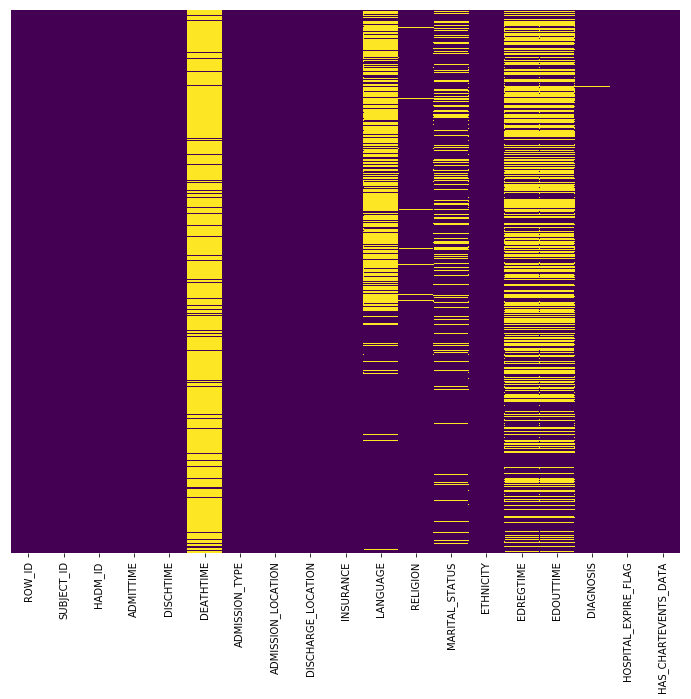

In [10]:
#Check for missing values
plt.figure(figsize = (12,10))
sns.heatmap(adm.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

Since a dead person cannot be readmitted, it is safe to drop the #DEATHTIME column

In [11]:
adm.drop('DEATHTIME', axis = 1, inplace = True)

In [12]:
adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1


### Get the next admission date if it exists

In this project, we need the next admission date if it exists. We can get this with the shift() function, but we need to verify the dates are in order.

In [13]:
# sort by subject_ID and admission date
#adm = adm.sort_values(['SUBJECT_ID','ADMITTIME'])
adm = adm.reset_index(drop = True)

In [14]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
adm['NEXT_ADMITTIME'] = adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
adm['NEXT_ADMISSION_TYPE'] = adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

Since we want to predict UNPLANNED re-admissions, we should filter out the ELECTIVE next admissions

In [15]:
# get rows where next admission is elective and replace with naT or nan
rows = adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [16]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
adm = adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [17]:

# calculate the number of days between discharge and next admission# calcu 
adm['DAYS_NEXT_ADMIT']=  adm.NEXT_ADMITTIME.subtract(adm.DISCHTIME).dt.total_seconds()/(24*60*60)


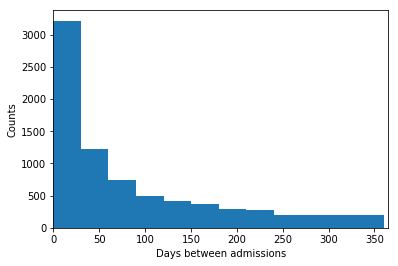

In [18]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter

plt.hist(adm.loc[~adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [19]:
print('Number with a readmission:', (~adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(adm))

Number with a readmission: 11399
Total Number: 58976


### Load the notes.csv file

In [20]:
notes = pd.read_csv('NOTEEVENTS.csv') #read in the notes data

c:\users\abayomi\appdata\local\programs\python\python35\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [22]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [23]:
notes.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,CGID,ISERROR
count,2.083180e+06,2.083180e+06,1.851344e+06,1.246404e+06,886.0
mean,1.041590e+06,3.242564e+04,1.498796e+05,1.771630e+04,1.0
std,6.013624e+05,2.755425e+04,2.878059e+04,2.158703e+03,0.0
min,1.000000e+00,2.000000e+00,1.000010e+05,1.401000e+04,1.0
25%,5.207958e+05,1.146500e+04,1.251950e+05,1.580300e+04,1.0
50%,1.041590e+06,2.344400e+04,1.496010e+05,1.759300e+04,1.0
75%,1.562385e+06,5.077200e+04,1.748120e+05,1.959900e+04,1.0
max,2.083180e+06,9.999900e+04,1.999990e+05,2.157000e+04,1.0


In [24]:
notes.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [25]:
notes_discharge_sum = notes.loc[notes.CATEGORY == 'Discharge summary']

In [26]:
notes_discharge_sum_last  = (notes_discharge_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert notes_discharge_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [27]:
notes = pd.merge(adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE']],
                        notes_discharge_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(adm) == len(notes), 'Number of rows increased'

In [28]:
notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [29]:
notes_clean = notes.loc[notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [30]:
print('Fraction of missing notes:', notes_clean.TEXT.isnull().sum() / len(notes_clean))
print('Fraction notes with newlines:', notes_clean.TEXT.str.contains('\n').sum() / len(notes_clean))
print('Fraction notes with carriage returns:', notes_clean.TEXT.str.contains('\r').sum() / len(notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


In [31]:
notes_clean['OUTPUT_LABEL'] = (notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')
notes_clean['OUTPUT_LABEL'].unique()

array([0, 1], dtype=int64)

In [32]:
print('Number of positive samples:', (notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


### Create a training, validation and testing dataset

In [33]:
# shuffle the samples
notes_clean = notes_clean.sample(n = len(notes_clean), random_state = 42)
notes_clean = notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
valid_test=notes_clean.sample(frac=0.30,random_state=42)

test_data = valid_test.sample(frac = 0.5, random_state = 42)
valid_data = valid_test.drop(test_data.index)

# use the rest of the data as training data
train_data= notes_clean.drop(valid_test.index)

In [34]:
# (Hey boss, do you understand this code below? Why did the guy print out the prevalence with respect to the output label?)
#(Also why did he create an output label and turn it to an 'int' when it is obviously a 'categorical' datatype?)

print('Test prevalence(n = %d):'%len(test_data),test_data.OUTPUT_LABEL.sum() / len(test_data))
print('Valid prevalence(n = %d):'%len(valid_data),valid_data.OUTPUT_LABEL.sum()/ len(valid_data))
print('Train all prevalence(n = %d):'%len(train_data), train_data.OUTPUT_LABEL.sum()/ len(train_data))
print('all samples (n = %d)'%len(notes_clean))
assert len(notes_clean) == (len(test_data)+len(valid_data)+len(train_data)), 'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options:

* balance the data by sub-sampling the negatives
* balance the data by over-sampling the positives
* create synthetic data (e.g. SMOTE)
In this example, we will sub-sample the negatives

In [35]:
# split the training data into positive and negative
rows_pos = train_data.OUTPUT_LABEL == 1
df_train_pos = train_data.loc[rows_pos]
df_train_neg = train_data.loc[~rows_pos]

# merge the balanced data
train_data= pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = train_data.sample(n = len(train_data), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(train_data), train_data.OUTPUT_LABEL.sum()/ len(train_data))

Train prevalence (n = 4184): 0.5


### Step 2: Preprocess text data
Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made

* how to pre-process the words
* how to count the words
* which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the pre-processing in two ways:

* modify the original dataframe TEXT column
* pre-process as part of your pipeline so you don't edit the original data (allows you try out a few options easily)


In [36]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [37]:
# preprocess the text to deal with known issues
train_data = preprocess_text(train_data)
valid_data = preprocess_text(valid_data)
test_data = preprocess_text(test_data)

In [38]:
import nltk
from nltk import word_tokenize
import string

In [39]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abayomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
print (string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [41]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(train_data.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x0000004908E3AAE8>,
        vocabulary=None)

In [43]:
neg_doc_matrix = vect.transform(train_data[train_data.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(train_data[train_data.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

In [44]:
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,71054,76756,147810
and,62455,71658,134113
to,53226,62085,115311
of,51303,60491,111794
was,48074,53521,101595
with,38036,44583,82619
a,35428,41629,77057
on,32290,39765,72055
mg,27718,39045,66763
in,29567,34755,64322


In [45]:
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)

In [46]:
d

the                 147810
and                 134113
to                  115311
of                  111794
was                 101595
with                 82619
a                    77057
on                   72055
mg                   66763
in                   64322
for                  60725
tablet               53342
no                   50662
name                 48671
is                   43568
po                   41596
patient              41091
s                    40394
he                   37340
blood                34560
at                   33501
daily                33378
sig                  33065
as                   32324
or                   32156
she                  30378
hospital             30334
discharge            30307
one                  30153
day                  30079
                     ...  
seek                   187
sized                  187
nonspecific            187
frequently             187
intuba                 187
vocal                  186
c

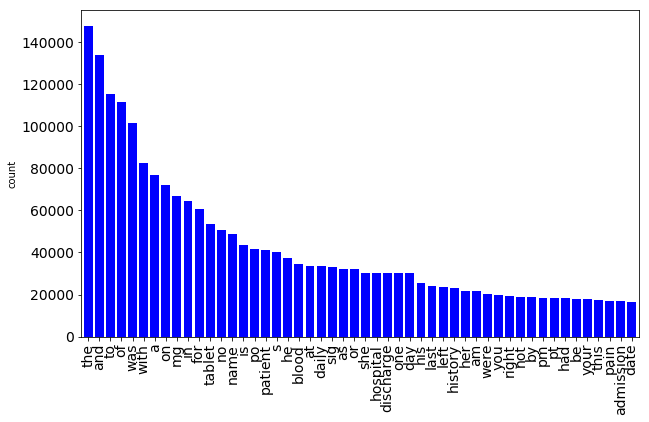

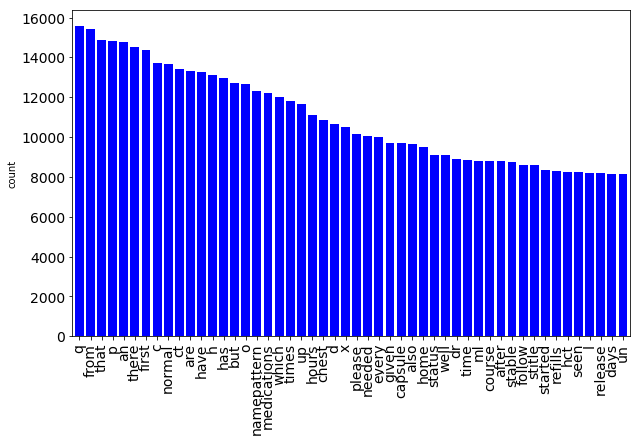

In [47]:
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [48]:
the_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'I', 'which', 'are',
                  'should','if','it','been','who','during', 'x']


In [49]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = the_stop_words)
# this could take a while
vect.fit(train_data.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also', 'I', 'which', 'are', 'should', 'if', 'it', 'been', 'who', 'during', 'x'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x0000004908E3AAE8>,
        vocabulary=None)

In [50]:
X_train_tf = vect.transform(train_data.TEXT.values)
X_valid_tf = vect.transform(valid_data.TEXT.values)

In [51]:
y_train = train_data.OUTPUT_LABEL
y_valid = valid_data.OUTPUT_LABEL

### Build a predictive model with Logistic regression

In [52]:
# First logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [54]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 1 1 1 1 1 1 1 1]
[0.58060951 0.72304897 0.23512958 0.50055966 0.40128289 0.55359575
 0.50784269 0.75093619 0.72847231 0.68208305]


In [55]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

In [56]:
def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

In [57]:
def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

In [58]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

In [59]:
def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

In [60]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

Train AUC:0.755
Valid AUC:0.705
Train accuracy:0.694
Valid accuracy:0.679
Train recall:0.665
Valid recall:0.648
Train precision:0.705
Valid precision:0.109
Train specificity:0.722
Valid specificity:0.680
Train prevalence:0.500
Valid prevalence:0.057


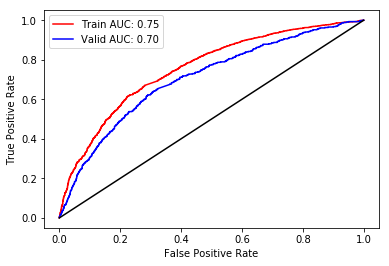

In [61]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.savefig('AUROC1.jpeg', format = 'jpeg', dpi = 300)

#### Using Decision tree

In [62]:
from sklearn import tree
d_tree = tree.DecisionTreeClassifier(random_state = 50)
d_tree.fit(X_train_tf, y_train)

model2 = d_tree
y_train_predict = model2.predict_proba(X_train_tf)[:,1]
y_valid_predict = model2.predict_proba(X_valid_tf)[:,1]

print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 1 1 1 1 1 1 1 1]
[0.58060951 0.72304897 0.23512958 0.50055966 0.40128289 0.55359575
 0.50784269 0.75093619 0.72847231 0.68208305]


In [63]:
fp_train, tp_train, threshold_train = roc_curve(y_train, y_train_predict)
fp_valid, tp_valid, threshold_valid = roc_curve(y_valid, y_valid_predict)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_predict)
auc_valid = roc_auc_score(y_valid, y_valid_predict)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

Train AUC:1.000
Valid AUC:0.570


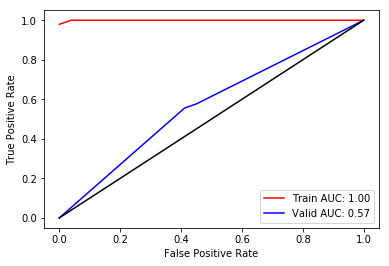

In [64]:
plt.plot(fp_train, tp_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fp_valid, tp_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.savefig('Decision tree.jpg', format = 'jpg')

#### Improve the model by making informed decisions from data exploration

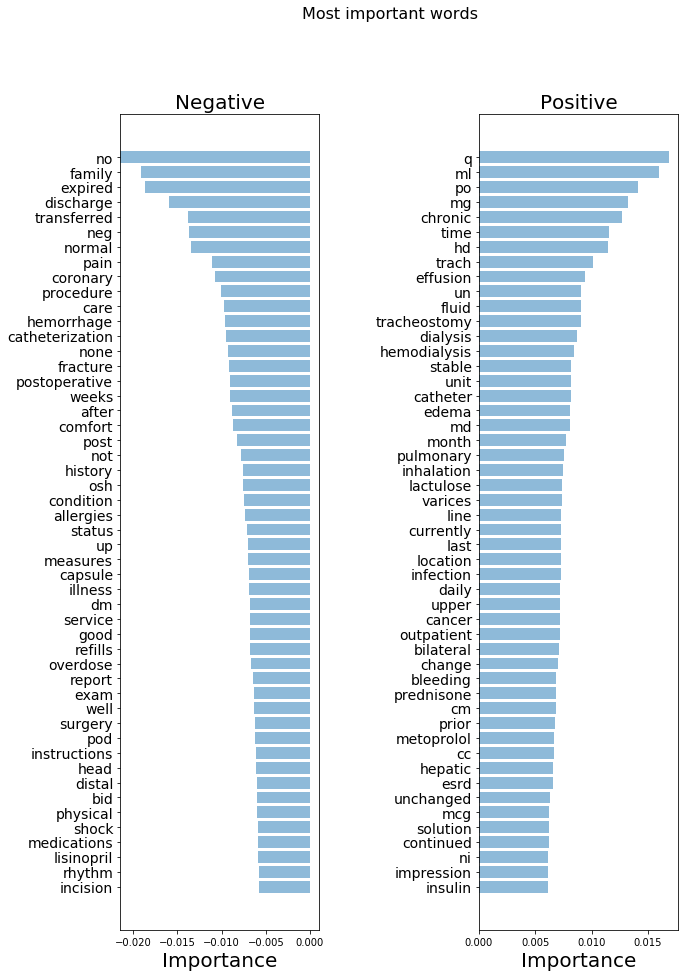

In [65]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    fig.savefig('Words in order of relevance.jpg')
    
importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")


In [66]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

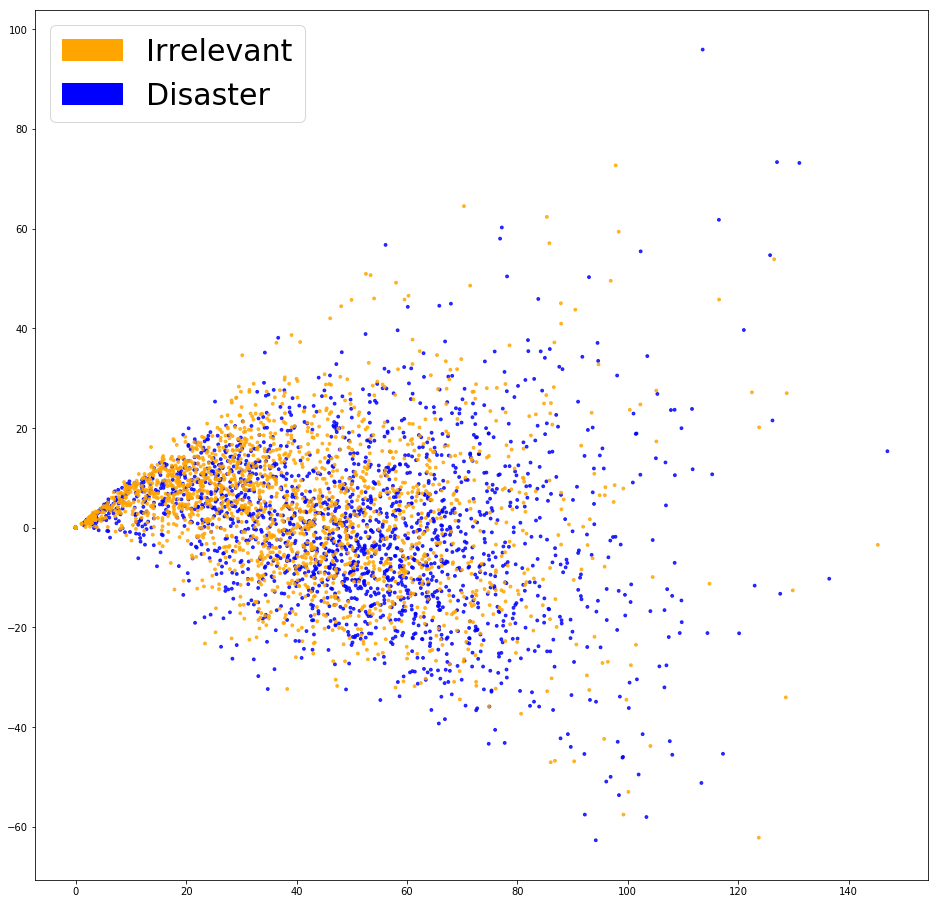

In [67]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tf, y_train)
plt.show()

#### Working on the test data to predict y_test

In [68]:
X_test_tf = vect.transform(test_data.TEXT.values)
y_test = test_data.OUTPUT_LABEL


y_test_preds = model.predict_proba(X_test_tf)[:,1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

In [69]:
y_test_preds_count = clf.predict(X_test_tf)

In [70]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_test_preds):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_test_preds, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_test_preds, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_test_preds, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_test_preds)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_test_preds_count)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.676, precision = 0.910, recall = 0.676, f1 = 0.760


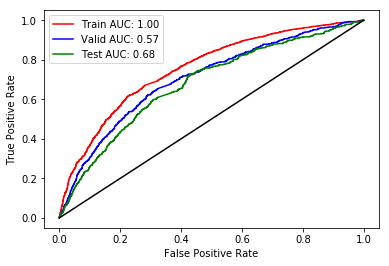

In [71]:
plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.savefig('AUROC.jpg', format = 'jpg', dpi = 300)